# 気象統計をもとにした特徴量を作成していく

* 米国海洋大気庁(NOAA)から各州の最大都市近郊の気象データを取得した。
    * TX ... 最大都市=Houston, 観測地点=William P. Hobby Airport
    * WI ... 最大都市=MILWAUKEE, 観測地点=MILWAUKEE MITCHELL AIRPORT
    * CA ... 最大都市=Los Angeles, 観測地点=LOS ANGELES DOWNTOWN USC
    * https://www.ncei.noaa.gov/access/search/data-search/global-summary-of-the-day?datasetabbv=GSOD&countryabbv=US&georegionabbv=&resolution=40&startDate=2011-01-29T00:00:00&endDate=2016-06-19T23:59:59&bbox=29.677,-95.302,29.627,-95.252&pageNum=1
    * Documentation: https://www.ncei.noaa.gov/data/global-summary-of-the-day/doc/readme.txt

## 値の説明
* LATITUDE, LONGITUDE, ELEVATION ... 緯度、経度、標高
* TEMP ... 平均気温。気温 t に対して (t - 32) / 1.8 で摂氏になる。 
* DEWP ... 平均露点温度・
* SLP ...平均海面気圧(mb)
* STP ...平均局圧（mb）
* VISIB ...平均視認性（マイル）
* WDSP ... 平均風速(ノット)
* MXSPD ... 最大持続風速
* GUST ... 最大瞬間風速
* MAX ... 最高気温
* MIN ... 最低気温
* PRCP ... 降水量 (.01 inches)
* SNDP ... 雪の深さ（.1 inches）
* FRSHTT ...「霧」「雨または霧雨」「雪又は氷の粒」「雹」「雷」「トルネード又はFunnel Cloud」の発生を示す。
    * 1が発生で、６桁の数字からなる。例)「雹」のみ発生なら「000100」

## 用いたらいいんじゃないか、という特徴量
* 平均気温、最高気温、最低気温(TEMP, MAX, MIN)
* 前日との平均気温の差 ... 急に暑くなったり寒くなったりしたら季節商品が売れるかも
* 最高気温と最低気温の差 ... 寒暖差による体調への影響が購買に影響するかも

* 気圧(STP) ... 気圧が原因の体調不良が購買に影響するかも
* 平均風速(WDSP) ... 風が強い日に買い物に出たくない
* 降水量(PRCP) ... 雨の日に外に出たくない
* 雪の深さ(SNDP) ... 雪が積もってたら外出したくない

* (FRSHTT)の各値
* (FRSHTT)の前日 ... 悪天候になる前日は、その備えのための売り上げが伸びるかも
    * 注) 「悪天候になる前日」とは、「翌日も悪天候な悪天候の日」は含まない

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from datetime import datetime as dt
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 300)

In [11]:
import sys
# メモリ確認用 https://qiita.com/AnchorBlues/items/883790e43417640140aa
print("{}{: >25}{}{: >10}{}".format('|','Variable Name','|','Memory','|'))
print(" ------------------------------------ ")
for var_name in dir():
    if not var_name.startswith("_") and sys.getsizeof(eval(var_name)) > 10000: #ここだけアレンジ
        print("{}{: >25}{}{: >10}{}".format('|',var_name,'|',sys.getsizeof(eval(var_name)),'|'))

|            Variable Name|    Memory|
 ------------------------------------ 
|                       ca|    623210|
|                  data_ex|27770751002|
|                      tmp|   1916470|
|                       to|   1594906|
|                       tx|    623210|
|                       wi|    623210|


# TX

### 統合・情報削減

In [10]:
tx = pd.read_csv("./weather_data/raw_data/72244012918.csv")
for i in range(1,6):
    tmp = pd.read_csv(f"./weather_data/raw_data/72244012918 ({i}).csv")
    tx = pd.concat([tx,tmp])
tx.reset_index(drop=True, inplace=True)
tx = tx[["DATE", "TEMP", "MAX", "MIN", "STP", "WDSP", "PRCP", "SNDP", "FRSHTT"]]
len(tx)

2192

### 「前日との気温差」「日中の気温差」の特徴量を作る


In [11]:
tx["TEMP_DIFF_1D"] = tx["MAX"]-tx["MIN"]

In [12]:
tx["TEMP_DIFF_2D"] = tx["TEMP"].diff()

### FRSHTT を分ける

In [13]:
tmp = tx["FRSHTT"].astype(str).str.zfill(6).str.split("", expand=True)[list(range(1,7))]
tmp.columns = ["FOG", "RAIN", "SNOW", "HAIL", "THUND", "TORND"]
tx = pd.concat([tx, tmp], axis=1)

### 悪天候前日フラグ

In [14]:
tmp = (tx["FRSHTT"].diff(-1) != 0) & (tx["FRSHTT"] == 0)
tx["BAD_PREV"] = tmp.astype(int)

In [22]:
##########################
tx['BAD'] = tx['FRSHTT'].mask(tx['FRSHTT']>0, 1)

In [24]:
tx.drop("FRSHTT", axis=1, inplace=True)

### SNDP の欠損　(999.9) を 0 に、STPを４桁に

In [25]:
tx["SNDP"] = tx["SNDP"].replace(999.9, 0.0)
tx["STP"] = tx["STP"].mask(tx["STP"]<500, tx["STP"]+1000)

### STP_DIFF の作成

In [42]:
###########################
tx["STP_MEAN"] = tx["STP"].rolling(29, center=True).mean()
tx["STP_DIFF"] = tx["STP"] - tx["STP_MEAN"]
tx["STP_DIFF"] = tx["STP_DIFF"].round(2)
tx.drop("STP_MEAN", axis=1, inplace=True)


### cropping / date_id の付加

In [44]:
st = tx[tx["DATE"]=="2011-01-29"].index.item()
en = tx[tx["DATE"]=="2016-06-19"].index.item()
tx = tx[st:en+1].reset_index(drop=True)

In [45]:
tmp = []
for i in range(len(tx)):
    tmp.append(f"d_{i+1}")
tx["date_id"]=tmp

In [46]:
tx

,DATE,TEMP,MAX,MIN,STP,WDSP,PRCP,SNDP,TEMP_DIFF_1D,TEMP_DIFF_2D,FOG,RAIN,SNOW,HAIL,THUND,TORND,BAD_PREV,BAD,STP_DIFF,date_id
0,2011-01-29,61.7,73.9,52.0,1016.6,6.4,0.00,0.0,21.9,4.6,0,0,0,0,0,0,1,0,-1.21,d_1
1,2011-01-30,66.2,71.1,64.0,1014.4,6.5,0.00,0.0,7.1,4.5,0,1,0,0,0,0,0,1,-3.54,d_2
2,2011-01-31,62.6,75.9,55.0,1013.5,5.2,0.10,0.0,20.9,-3.6,1,0,0,0,0,0,0,1,-4.64,d_3
3,2011-02-01,55.6,71.6,37.0,1009.1,13.0,0.01,0.0,34.6,-7.0,1,1,0,0,0,0,0,1,-9.41,d_4
4,2011-02-02,29.7,37.0,23.0,1026.3,14.4,0.13,0.0,14.0,-25.9,0,0,0,0,0,0,0,0,7.42,d_5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,85.7,95.0,79.0,1012.0,7.3,0.00,0.0,16.0,1.1,0,0,0,0,0,0,0,0,-0.93,d_1965
1965,2016-06-16,85.5,95.0,78.1,1013.1,6.0,0.00,0.0,16.9,-0.2,0,0,0,0,0,0,0,0,0.09,d_1966
1966,2016-06-17,85.0,96.1,77.0,1012.5,4.6,0.00,0.0,19.1,-0.5,0,0,0,0,0,0,1,0,-0.62,d_1967
1967,2016-06-18,84.5,97.0,77.0,1012.9,4.9,0.00,0.0,20.0,-0.5,0,1,0,0,1,0,0,1,-0.37,d_1968


### def

In [47]:
def gen_cal_data(csv):
    tx = pd.read_csv(f"./weather_data/raw_data/{csv}.csv")
    for i in range(1,6):
        tmp = pd.read_csv(f"./weather_data/raw_data/{csv} ({i}).csv")
        tx = pd.concat([tx,tmp])
    tx.reset_index(drop=True, inplace=True)
    tx = tx[["DATE", "TEMP", "MAX", "MIN", "STP", "WDSP", "PRCP", "SNDP", "FRSHTT"]]

    tx["TEMP_DIFF_1D"] = tx["MAX"]-tx["MIN"]
    tx["TEMP_DIFF_2D"] = tx["TEMP"].diff()

    tmp = tx["FRSHTT"].astype(str).str.zfill(6).str.split("", expand=True)[list(range(1,7))]
    tmp.columns = ["FOG", "RAIN", "SNOW", "HAIL", "THUND", "TORND"]
    tx = pd.concat([tx, tmp], axis=1)

    tmp = (tx["FRSHTT"].diff(-1) != 0) & (tx["FRSHTT"] == 0)
    tx["BAD_PREV"] = tmp.astype(int)
    tx['BAD'] = tx['FRSHTT'].mask(tx['FRSHTT']>0, 1)
    tx.drop("FRSHTT", axis=1, inplace=True)

    tx["SNDP"] = tx["SNDP"].replace(999.9, 0.0)
    tx["STP"] = tx["STP"].mask(tx["STP"]<500, tx["STP"]+1000)

    tx["STP_MEAN"] = tx["STP"].rolling(29, center=True).mean()
    tx["STP_DIFF"] = tx["STP"] - tx["STP_MEAN"]
    tx["STP_DIFF"] = tx["STP_DIFF"].round(2)
    tx.drop("STP_MEAN", axis=1, inplace=True)

    st = tx[tx["DATE"]=="2011-01-29"].index.item()
    en = tx[tx["DATE"]=="2016-06-19"].index.item()
    tx = tx[st:en+1].reset_index(drop=True)

    tmp = []
    for i in range(len(tx)):
        tmp.append(f"d_{i+1}")
    tx["date_id"]=tmp
    
    return tx

# WI

In [48]:
wi = gen_cal_data("72640014839")
wi.max()

DATE            2016-06-19
TEMP                 89.20
MAX                9999.90
MIN                  79.00
STP                1013.40
WDSP                 22.10
PRCP                  2.50
SNDP                 16.90
TEMP_DIFF_1D       9972.90
TEMP_DIFF_2D         22.30
FOG                      1
RAIN                     1
SNOW                     1
HAIL                     1
THUND                    1
TORND                    0
BAD_PREV                 1
BAD                      1
STP_DIFF             17.94
date_id              d_999
dtype: object

In [49]:
# 2016/4/3 ~ 2016/4/4 の MAX が異常値(9999.9)のため、2016/4/2 の値で置き換える
wi["MAX"] = wi["MAX"].mask(wi["MAX"]>1000, 52)
# TEMP_DIFF_1D も更新
wi["TEMP_DIFF_1D"] = wi["MAX"]-wi["MIN"]

In [50]:
wi.head()

,DATE,TEMP,MAX,MIN,STP,WDSP,PRCP,SNDP,TEMP_DIFF_1D,TEMP_DIFF_2D,FOG,RAIN,SNOW,HAIL,THUND,TORND,BAD_PREV,BAD,STP_DIFF,date_id
0,2011-01-29,29.4,34.0,24.1,984.5,7.0,0.00,5.1,9.9,3.0,0,1,1,0,0,0,0,1,-7.50,d_1
1,2011-01-30,26.4,34.0,23.0,997.2,7.6,0.00,5.1,11.0,-3.0,0,0,1,0,0,0,0,1,5.58,d_2
2,2011-01-31,22.9,26.6,19.4,1003.9,12.2,0.00,5.9,7.2,-3.5,1,0,1,0,0,0,0,1,12.84,d_3
3,2011-02-01,22.0,24.8,19.4,998.5,18.2,0.21,5.1,5.4,-0.9,0,0,1,0,0,0,0,1,7.11,d_4
4,2011-02-02,20.7,24.1,17.6,997.0,22.1,0.48,16.9,6.5,-1.3,0,0,1,0,1,0,0,1,5.40,d_5


# CA

In [51]:
ca = gen_cal_data("72287493134")
ca.max()

DATE            2016-06-19
TEMP                 86.70
MAX                 102.90
MIN                9999.90
STP                1021.90
WDSP                  7.60
PRCP                  2.44
SNDP                  0.00
TEMP_DIFF_1D         41.10
TEMP_DIFF_2D         16.30
FOG                      1
RAIN                     1
SNOW                     0
HAIL                     0
THUND                    0
TORND                    0
BAD_PREV                 1
BAD                      1
STP_DIFF              9.47
date_id              d_999
dtype: object

In [52]:
# 2012/7/3 の MIN が異常値(9999.9)のため、2012/7/2 の値で置き換える
ca["MIN"] = ca["MIN"].mask(ca["MIN"]>1000, 62.6)
# TEMP_DIFF_1D も更新
ca["TEMP_DIFF_1D"] = ca["MAX"]-ca["MIN"]

In [53]:
ca.head()

,DATE,TEMP,MAX,MIN,STP,WDSP,PRCP,SNDP,TEMP_DIFF_1D,TEMP_DIFF_2D,FOG,RAIN,SNOW,HAIL,THUND,TORND,BAD_PREV,BAD,STP_DIFF,date_id
0,2011-01-29,55.7,69.1,45.0,1011.1,0.7,0.00,0.0,24.1,-5.3,0,0,0,0,0,0,1,0,-0.59,d_1
1,2011-01-30,55.3,62.1,53.1,1013.4,1.1,0.00,0.0,9.0,-0.4,0,1,0,0,0,0,0,1,1.68,d_2
2,2011-01-31,54.0,64.9,45.0,1012.2,0.8,0.21,0.0,19.9,-1.3,0,0,0,0,0,0,0,0,0.32,d_3
3,2011-02-01,55.3,63.0,48.2,1011.8,0.6,0.00,0.0,14.8,1.3,0,0,0,0,0,0,0,0,-0.33,d_4
4,2011-02-02,53.4,64.0,41.0,1015.0,0.6,0.00,0.0,23.0,-1.9,0,0,0,0,0,0,0,0,2.76,d_5


# Save Data

In [54]:
tx.to_csv('./weather_data/tx.csv', index=False)
wi.to_csv('./weather_data/wi.csv', index=False)
ca.to_csv('./weather_data/ca.csv', index=False)

# Merge to data_ex

In [4]:
wi["state"]="WI"
tx["state"]="TX"
ca["state"]="CA"
to = pd.concat([wi, tx, ca])
to["date_id"] = to["date_id"].str[2:].astype(int)
# data_ex = pd.read_csv("./data/backup/data_ex3.csv")
# data_ex = pd.read_csv("./data/backup/data_ex6B.csv")
# data_ex["state"] = data_ex["id"].str.split(pat='_', expand=True)[3]

In [8]:
data_ex.head()

,id,item_id,date_id,num,date,wm_yr_wk,wday,month,year,event_name_1,event_name_2,snap_CA,snap_TX,snap_WI,sell_price,dept_id_FOODS_1,dept_id_FOODS_2,dept_id_FOODS_3,dept_id_HOBBIES_1,dept_id_HOBBIES_2,dept_id_HOUSEHOLD_1,dept_id_HOUSEHOLD_2,cat_id_FOODS,cat_id_HOBBIES,cat_id_HOUSEHOLD,store_id_CA_1,store_id_CA_2,store_id_CA_3,store_id_CA_4,store_id_TX_1,store_id_TX_2,store_id_TX_3,store_id_WI_1,store_id_WI_2,store_id_WI_3,state_id_CA,state_id_TX,state_id_WI,event_type_1_Cultural,event_type_1_National,event_type_1_Religious,event_type_1_Sporting,event_type_1_nan,28day_sales,new_item,pri_fluc,TEMP,MAX,MIN,STP,WDSP,PRCP,SNDP,TEMP_DIFF_1D,TEMP_DIFF_2D,FOG,RAIN,SNOW,HAIL,THUND,TORND,BAD_PREV,corr,28_55_sales,state
0,HOBBIES_1_008_CA_1_validation,1444,1,12,29,11101,1,1,2011,30,4,0,0,0,0.46,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,57.30,0,0.0,55.7,69.1,45.0,1011.1,0.7,0.00,0.0,24.1,-5.3,0,0,0,0,0,0,1,-0.730432,57.30,CA
1,HOBBIES_1_008_CA_3_validation,1444,1,11,29,11101,1,1,2011,30,4,0,0,0,0.46,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,230.38,0,0.0,55.7,69.1,45.0,1011.1,0.7,0.00,0.0,24.1,-5.3,0,0,0,0,0,0,1,-0.730432,230.38,CA
2,HOBBIES_1_008_CA_1_validation,1444,2,15,30,11101,2,1,2011,30,4,0,0,0,0.46,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,57.30,0,0.0,55.3,62.1,53.1,1013.4,1.1,0.00,0.0,9.0,-0.4,0,1,0,0,0,0,0,-0.730432,57.30,CA
3,HOBBIES_1_008_CA_3_validation,1444,2,12,30,11101,2,1,2011,30,4,0,0,0,0.46,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,230.38,0,0.0,55.3,62.1,53.1,1013.4,1.1,0.00,0.0,9.0,-0.4,0,1,0,0,0,0,0,-0.730432,230.38,CA
4,HOBBIES_1_008_CA_1_validation,1444,3,0,31,11101,3,1,2011,30,4,0,0,0,0.46,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,57.30,0,0.0,54.0,64.9,45.0,1012.2,0.8,0.21,0.0,19.9,-1.3,0,0,0,0,0,0,0,-0.730432,57.30,CA


In [7]:
# data_ex = pd.merge(data_ex, to, on=['date_id', 'state'])
# data_ex.drop(["state"], axis=1, inplace=True)
# data_ex.to_csv('./data/backup/data_ex7B.csv', index=False)

# 特徴量の可視化

In [3]:
tx = pd.read_csv('./weather_data/tx.csv')
wi = pd.read_csv('./weather_data/wi.csv')
ca = pd.read_csv('./weather_data/ca.csv')

In [58]:
wi["state"]="WI"
tx["state"]="TX"
ca["state"]="CA"
tmp = pd.concat([wi, tx, ca])

In [59]:
t = tmp["DATE"].str.split(pat='-', expand=True)
tmp["year"] = t[0].astype(int)
tmp["month"] = t[1].astype(int)
tmp["day"] = t[2].astype(int)
tmp = tmp.reset_index(drop=True)

In [60]:
tmp["DATE"] = pd.to_datetime(tmp["DATE"])

## Temperature

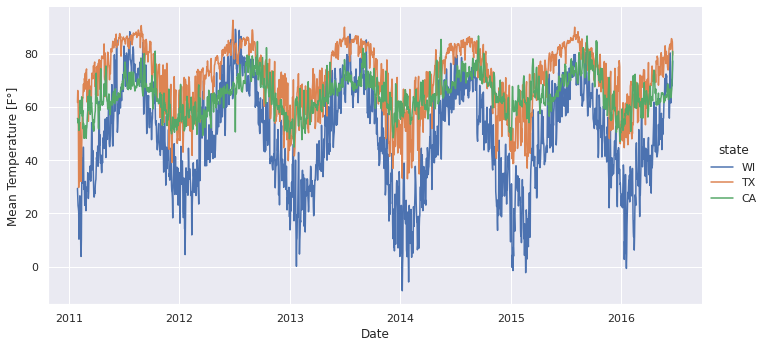

In [17]:
g = sns.relplot(x="DATE", y="TEMP", 
                data=tmp, 
                kind='line', aspect=2, hue="state")
g.set(xlabel='Date', ylabel='Mean Temperature [F°]')

## STP

In [12]:
tmp["STP"] = tmp["STP"].mask(tmp["STP"]<500, tmp["STP"]+1000)

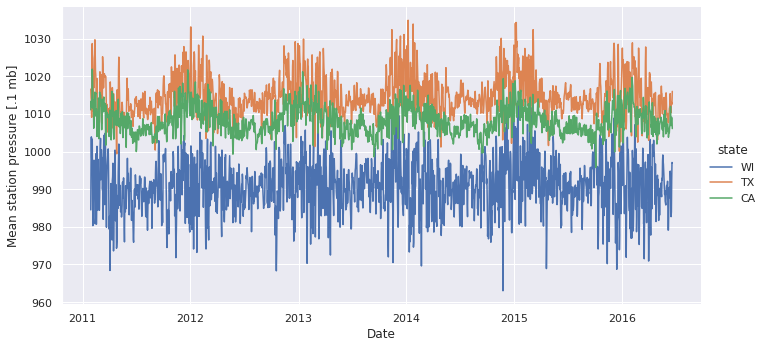

In [15]:
g = sns.relplot(x="DATE", y="STP", 
                data=tmp, 
                kind='line', aspect=2, hue="state")
g.set(xlabel='Date', ylabel='Mean station pressure [.1 mb]')


(980.0, 1025.0)

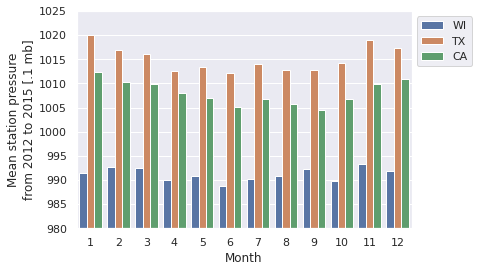

In [65]:
tmpdata = tmp[(tmp["year"]>2011) & (tmp["year"]<2016)].groupby(['month', "state"])["STP"].mean().reset_index().sort_values('state', ascending=False)
g = sns.barplot(x="month", y="STP", 
            hue="state", 
            data=tmpdata)
g.set(xlabel='Month', ylabel='Mean station pressure\nfrom 2012 to 2015 [.1 mb]')
plt.legend(bbox_to_anchor=(1, 1), loc=2)
plt.ylim(980,1025)

### STP_DIFF

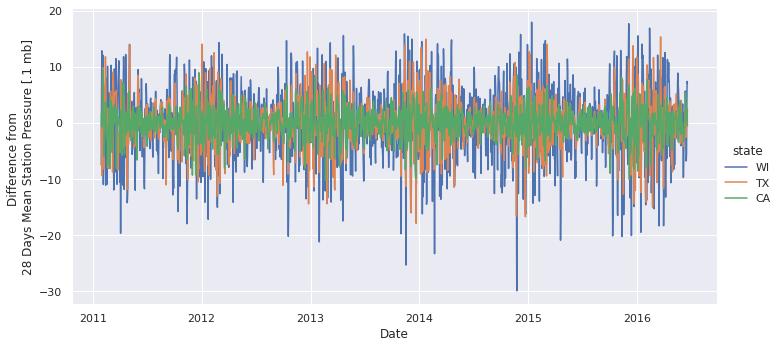

In [76]:
g = sns.relplot(x="DATE", y="STP_DIFF", 
                data=tmp, 
                kind='line', aspect=2, hue="state")
g.set(xlabel='Date', ylabel='Difference from \n28 Days Mean Station Pressure [.1 mb]')

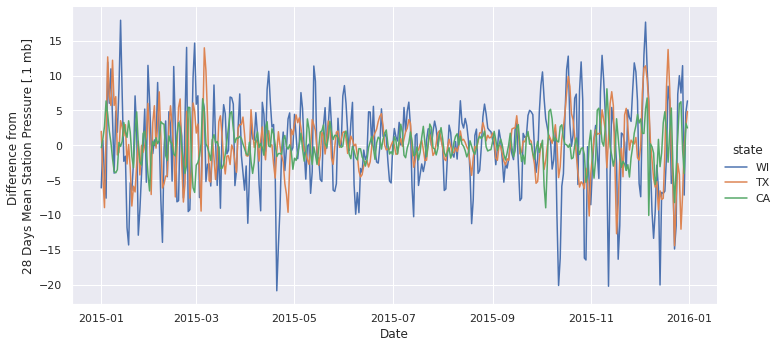

In [73]:
g = sns.relplot(x="DATE", y="STP_DIFF", 
                data=tmp[(tmp["year"]>2014) & (tmp["year"]<2016)], 
                kind='line', aspect=2, hue="state")
g.set(xlabel='Date', ylabel='Difference from \n28 Days Mean Station Pressure [.1 mb]')

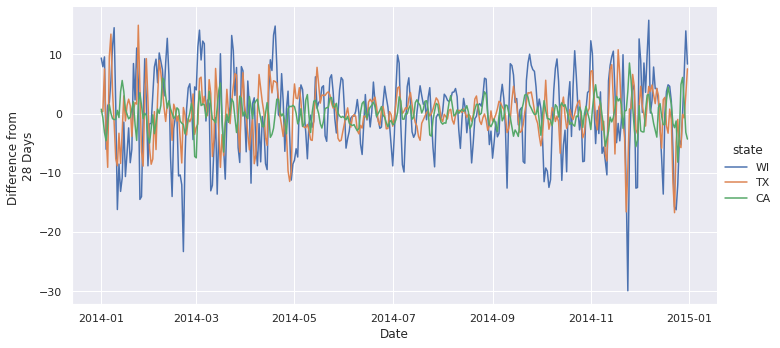

In [75]:
g = sns.relplot(x="DATE", y="STP_DIFF", 
                data=tmp[(tmp["year"]>2013) & (tmp["year"]<2015)], 
                kind='line', aspect=2, hue="state")
g.set(xlabel='Date', ylabel='Difference from \n28 Days')

## Wind Speed

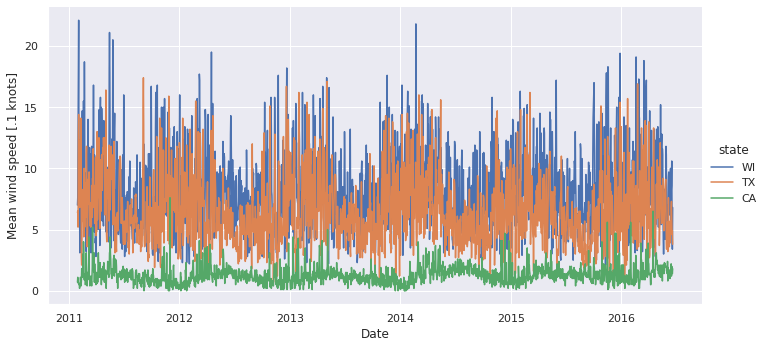

In [18]:
g = sns.relplot(x="DATE", y="WDSP", data=tmp, kind='line', aspect=2, hue="state")
g.set(xlabel='Date', ylabel='Mean wind speed [.1 knots]')


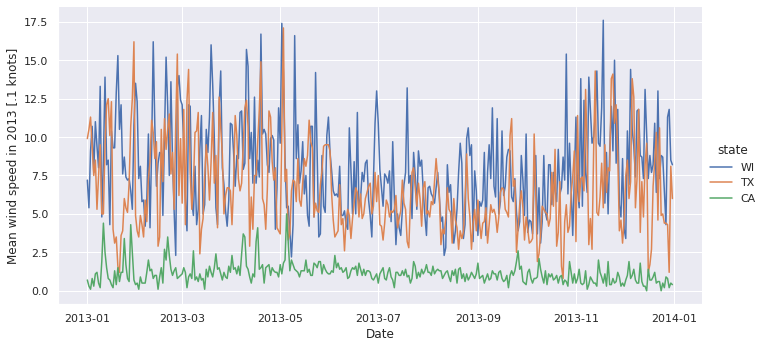

In [19]:
g = sns.relplot(x="DATE", y="WDSP", 
                data=tmp[tmp["year"]==2013], 
                kind='line', aspect=2, hue="state")
g.set(xlabel='Date', ylabel='Mean wind speed in 2013 [.1 knots]')

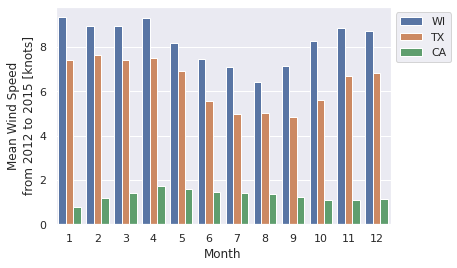

In [100]:
tmpdata = tmp[(tmp["year"]>2011) & (tmp["year"]<2016)].groupby(['month', "state"])["WDSP"].mean().reset_index().sort_values('state', ascending=False)
g = sns.barplot(x="month", y="WDSP", 
                data=tmpdata,
                hue="state")
g.set(xlabel='Month', ylabel='Mean Wind Speed\nfrom 2012 to 2015 [knots]')
plt.legend(bbox_to_anchor=(1, 1), loc=2)

## 降水量

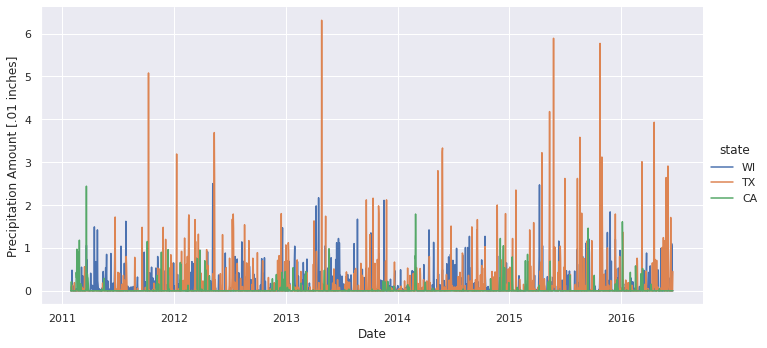

In [20]:
g = sns.relplot(x="DATE", y="PRCP", 
                data=tmp, 
                kind='line', aspect=2, hue="state")
g.set(xlabel='Date', ylabel='Precipitation Amount [.01 inches]')

[Text(0.5, 0, 'Month'),
 Text(0, 0.5, 'Cumulative Precipitation\nfrom 2012 to 2015 [.01 inches]')]

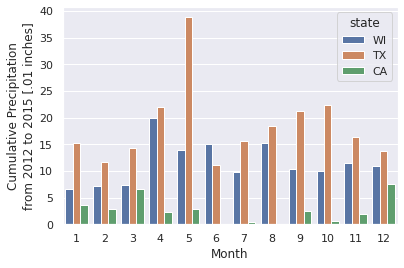

In [97]:
tmpdata = tmp[(tmp["year"]>2011) & (tmp["year"]<2016)].groupby(['month', "state"])["PRCP"].sum().reset_index().sort_values('state', ascending=False)
g = sns.barplot(x="month", y="PRCP", 
                hue="state", 
                data=tmpdata)
g.set(xlabel='Month', ylabel='Cumulative Precipitation\nfrom 2012 to 2015 [.01 inches]')

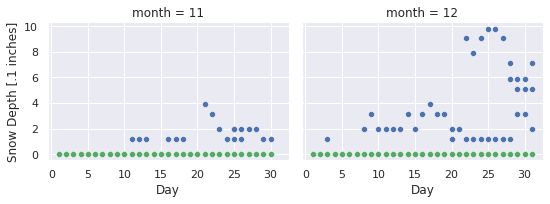

In [69]:
grid = sns.FacetGrid(tmp[(tmp["month"]>10) & (tmp["year"]>2011) & (tmp["year"]<2016)],
                     col="month", hue="state", height=3, aspect=1.3, margin_titles=True)
grid.map(sns.scatterplot, "day", "SNDP")
grid.set_axis_labels("Day", "Snow Depth [.1 inches]")

## 雪の深さ

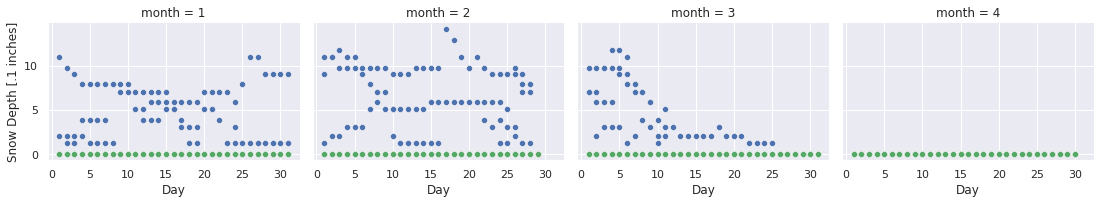

In [92]:
grid = sns.FacetGrid(tmp[(tmp["month"]<5) & (tmp["year"]>2011) & (tmp["year"]<2016)],
                     col="month", hue="state", height=3, aspect=1.3, margin_titles=True)
grid.map(sns.scatterplot, "day", "SNDP")
grid.set_axis_labels("Day", "Snow Depth [.1 inches]")

## 1日の気温差

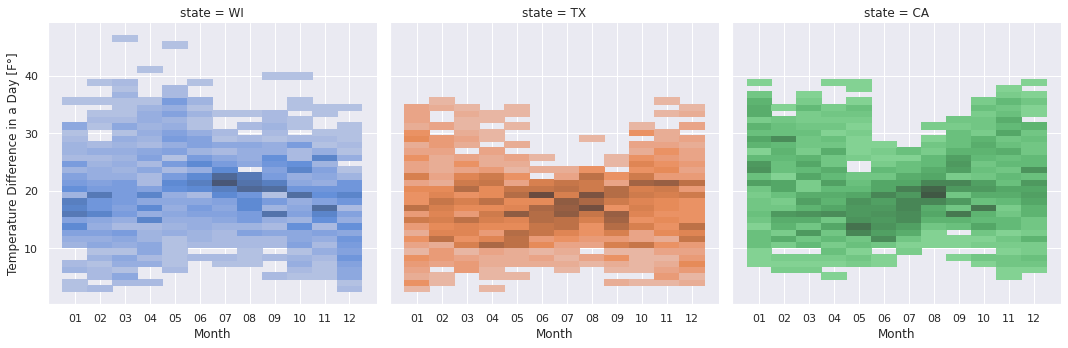

In [37]:
g = sns.displot(
    data=tmp[(tmp["DATE"] <= dt(2015,12,31)) & (dt(2012,1,1) <=tmp["DATE"])],
    x="month", 
    y="TEMP_DIFF_1D", 
    col="state", hue="state", legend=False)
g.set_axis_labels("Month", "Temperature Difference in a Day [F°]")

## 前日との気温差

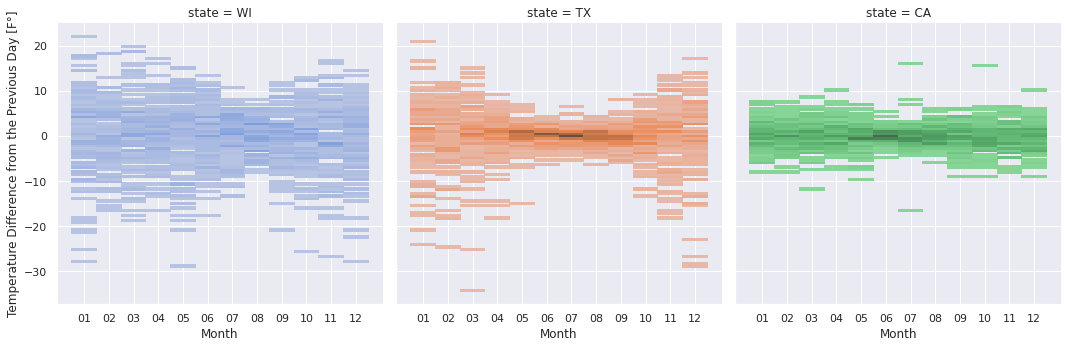

In [39]:
g = sns.displot(
    data=tmp[(tmp["DATE"] <= dt(2015,12,31)) & (dt(2012,1,1) <=tmp["DATE"])],
    x="month", 
    y="TEMP_DIFF_2D", 
    col="state", hue="state", legend=False)
g.set_axis_labels("Month", "Temperature Difference from the Previous Day [F°]")

Text(0.5, 1.0, 'Temperature Difference from the Previous Day [F°]')

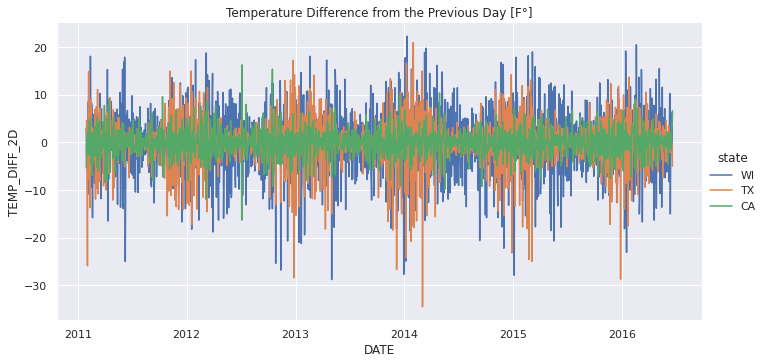

In [76]:
sns.relplot(x="DATE", y="TEMP_DIFF_2D", 
            data=tmp, 
            kind='line', aspect=2, hue="state")
plt.title('Temperature Difference from the Previous Day [F°]')

## 各種flag

### 「霧」 FLUG

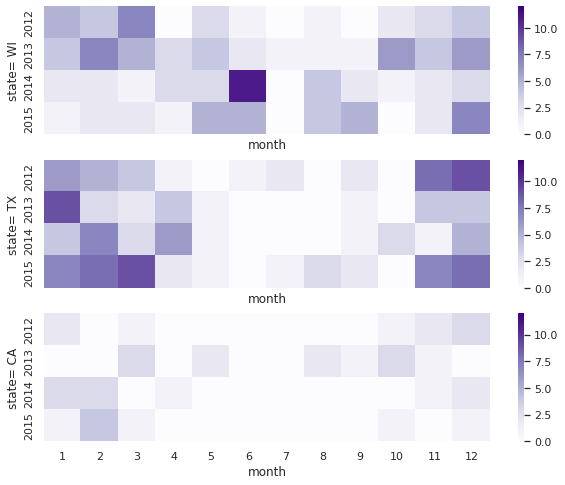

In [141]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True, sharey=True)

for i, s in enumerate(["WI", "TX", "CA"]):
    df_flights_pivot = pd.pivot_table(data=tmp[(tmp["year"]>2011) & (tmp["year"]<2016) & (tmp["state"]==s)], 
                                    values='FOG', columns='month', index='year', aggfunc=np.sum)
    g = sns.heatmap(df_flights_pivot, ax=axes[i], cmap="Purples", vmax=12, vmin=0)
    g.set_ylabel(f'state= {s}')


### 「雨」 FLAG

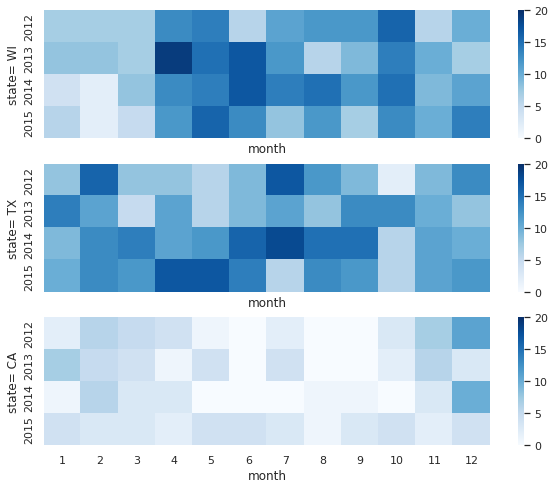

In [140]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True, sharey=True)

for i, s in enumerate(["WI", "TX", "CA"]):
    df_flights_pivot = pd.pivot_table(data=tmp[(tmp["year"]>2011) & (tmp["year"]<2016) & (tmp["state"]==s)], 
                                    values='RAIN', columns='month', index='year', aggfunc=np.sum)
    g = sns.heatmap(df_flights_pivot, ax=axes[i], cmap="Blues", vmax=20, vmin=0)
    g.set_ylabel(f'state= {s}')

### 「雪又は氷の粒」 FLAG

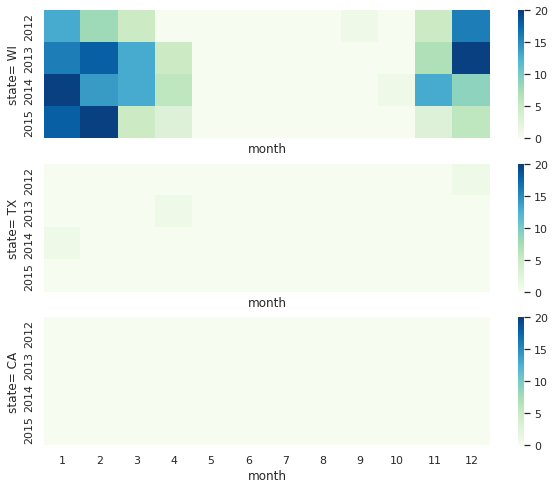

In [8]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True, sharey=True)

for i, s in enumerate(["WI", "TX", "CA"]):
    df_flights_pivot = pd.pivot_table(data=tmp[(tmp["year"]>2011) & (tmp["year"]<2016) & (tmp["state"]==s)], 
                                    values='SNOW', columns='month', index='year', aggfunc=np.sum)
    g = sns.heatmap(df_flights_pivot, ax=axes[i], cmap="GnBu", vmax=20, vmin=0)
    g.set_ylabel(f'state= {s}')

### 「雹」 FLAG

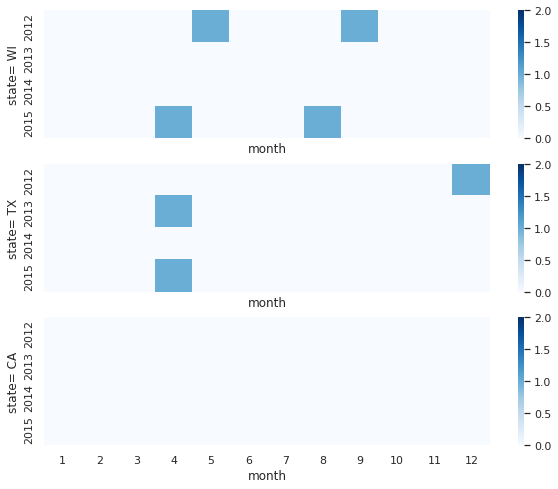

In [130]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True, sharey=True)

for i, s in enumerate(["WI", "TX", "CA"]):
    df_flights_pivot = pd.pivot_table(data=tmp[(tmp["year"]>2011) & (tmp["year"]<2016) & (tmp["state"]==s)], 
                                    values='HAIL', columns='month', index='year', aggfunc=np.sum)
    g = sns.heatmap(df_flights_pivot, ax=axes[i], cmap="Blues", vmax=2, vmin=0)
    g.set_ylabel(f'state= {s}')

### 「雷」 FLUG

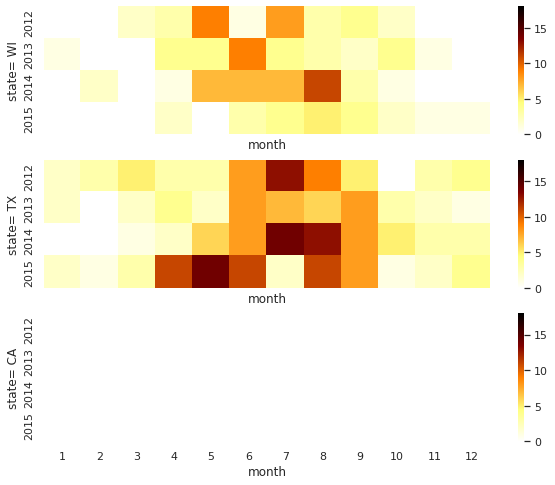

In [137]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True, sharey=True)

for i, s in enumerate(["WI", "TX", "CA"]):
    df_flights_pivot = pd.pivot_table(data=tmp[(tmp["year"]>2011) & (tmp["year"]<2016) & (tmp["state"]==s)], 
                                    values='THUND', columns='month', index='year', aggfunc=np.sum)
    g = sns.heatmap(df_flights_pivot, ax=axes[i], cmap="afmhot_r", vmax=18, vmin=0)
    g.set_ylabel(f'state= {s}')

### 「トルネード又はFunnel Cloud」 FLAG

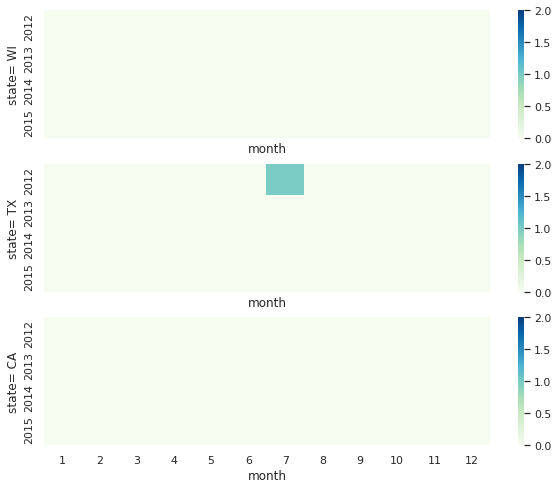

In [138]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True, sharey=True)

for i, s in enumerate(["WI", "TX", "CA"]):
    df_flights_pivot = pd.pivot_table(data=tmp[(tmp["year"]>2011) & (tmp["year"]<2016) & (tmp["state"]==s)], 
                                    values='TORND', columns='month', index='year', aggfunc=np.sum)
    g = sns.heatmap(df_flights_pivot, ax=axes[i], cmap="GnBu", vmax=2, vmin=0)
    g.set_ylabel(f'state= {s}')

### 「悪天候前日」 FLAG

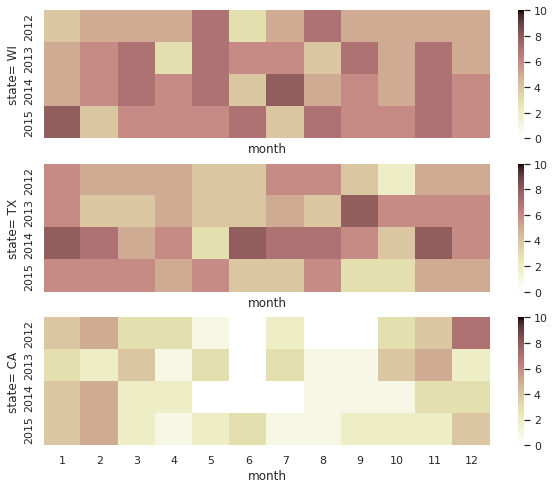

In [65]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True, sharey=True)

for i, s in enumerate(["WI", "TX", "CA"]):
    df_flights_pivot = pd.pivot_table(data=tmp[(tmp["year"]>2011) & (tmp["year"]<2016) & (tmp["state"]==s)], 
                                    values='BAD_PREV', columns='month', index='year', aggfunc=np.sum)
    g = sns.heatmap(df_flights_pivot, ax=axes[i], cmap="pink_r",vmax=10, vmin=0)
    g.set_ylabel(f'state= {s}')

### 「悪天候」FLAG

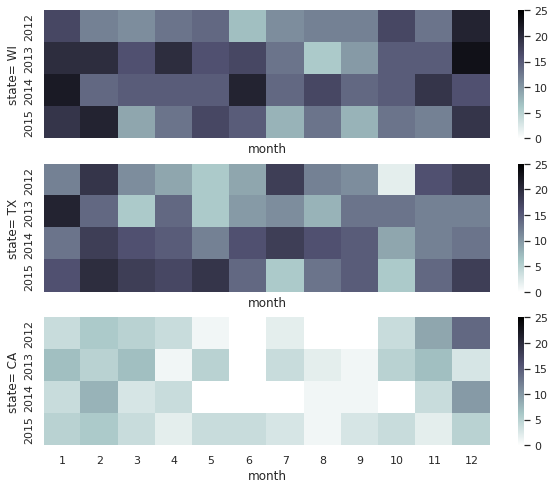

In [66]:
fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True, sharey=True)

for i, s in enumerate(["WI", "TX", "CA"]):
    df_flights_pivot = pd.pivot_table(data=tmp[(tmp["year"]>2011) & (tmp["year"]<2016) & (tmp["state"]==s)], 
                                    values='BAD', columns='month', index='year', aggfunc=np.sum)
    g = sns.heatmap(df_flights_pivot, ax=axes[i], cmap="bone_r",vmax=25, vmin=0)
    g.set_ylabel(f'state= {s}')

In [101]:
tmp.head()

,DATE,TEMP,MAX,MIN,STP,WDSP,PRCP,SNDP,TEMP_DIFF_1D,TEMP_DIFF_2D,FOG,RAIN,SNOW,HAIL,THUND,TORND,BAD_PREV,date_id,state,year,month,day
0,2011-01-29,29.4,34.0,24.1,984.5,7.0,0.00,5.1,9.9,3.0,0,1,1,0,0,0,0,d_1,WI,2011,1,29
1,2011-01-30,26.4,34.0,23.0,997.2,7.6,0.00,5.1,11.0,-3.0,0,0,1,0,0,0,0,d_2,WI,2011,1,30
2,2011-01-31,22.9,26.6,19.4,3.9,12.2,0.00,5.9,7.2,-3.5,1,0,1,0,0,0,0,d_3,WI,2011,1,31
3,2011-02-01,22.0,24.8,19.4,998.5,18.2,0.21,5.1,5.4,-0.9,0,0,1,0,0,0,0,d_4,WI,2011,2,1
4,2011-02-02,20.7,24.1,17.6,997.0,22.1,0.48,16.9,6.5,-1.3,0,0,1,0,1,0,0,d_5,WI,2011,2,2
